# Milestone 2

In [1]:
# Install missing packages
# %pip install cpi

In [1]:
#we import all the necessary librairies here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import ast
from datetime import datetime
import cpi


# # Make sure that we have the good rate for computing the inflation
# cpi.update()


In [3]:
#data paths
data_path = './data/'
#cmu_path = data_path+'MovieSummaries/'
acl_persona_path = data_path+'ACL_personas_dump/personas/'

## 1. Data cleaning and preprocessing

In this part we will import, clean and transform the data we will use for later analysis.

- We will first create a more complete movie dataset by merging the data from cmu with some useful data from imdb.
- Then, the dataset is cleaned and transformed to be used for later analysis.
- We perform the same cleaning for the character dataset.
- Once all the datasets are ready, we compute a fame score to quantisize the sucess of an actor. This a first version of the fame score that we will show as satisfying enough for the pre-analysis. It will be improved based on futur milestone with more complex computations.
- Finally, we load the dataset from ACL_personas_dump and merge it with the character one to get associate personas to each character.   

#### 1.1 Movie dataset

Let's first have a look at the cmu movie dataset more in details to see what we can do with it.

In [4]:
#Import the cmu movie dataset and print a sample of 5 random row in the dataset
cmu_movie_cols = ['wikiID',
                  'freebase_movID',
                  'movie_name',
                  'release_date',
                  'boxoffice',
                  'runtime',
                  'language',
                  'country',
                  'genre']

cmu_movies = pd.read_csv(data_path+'movie.metadata.tsv', sep='\t', names=cmu_movie_cols)
cmu_movies.sample(5)

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre
70389,36241861,/m/0k2ljkj,Tera Mera Vaada,2012-06-29,NaN,NaN,"{""/m/0fpd8_"": ""Hariyani"", ""/m/02hwsp1"": ""Harya...","{""/m/03rk0"": ""India""}","{""/m/02l7c8"": ""Romance Film""}"
53930,25927547,/m/0b6hts6,The Scarlet Dove,1961-03-10,NaN,86.0,{},"{""/m/02vzc"": ""Finland""}","{""/m/02n4kr"": ""Mystery"", ""/m/07s9rl0"": ""Drama""}"
34789,25593267,/m/09rv0sn,Janwar,1965,NaN,NaN,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/04t36"": ""Musical"", ""/m/02l7c8"": ""Romance ..."
8990,31581172,/m/0glqcdr,Bidrohi Padma,2006-04-14,NaN,144.0,"{""/m/01c7y"": ""Bengali Language""}",{},{}
65643,32711189,/m/07yk079,Oceans,2010-01-22,NaN,104.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/06mzp"": ""Switzerla...","{""/m/03q4nz"": ""World cinema"", ""/m/05h0n"": ""Nat..."


In [5]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikiID          81741 non-null  int64  
 1   freebase_movID  81741 non-null  object 
 2   movie_name      81741 non-null  object 
 3   release_date    74839 non-null  object 
 4   boxoffice       8401 non-null   float64
 5   runtime         61291 non-null  float64
 6   language        81741 non-null  object 
 7   country         81741 non-null  object 
 8   genre           81741 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 5.6+ MB


The first thing we see here is that we do not have a lot of boxoffice data for the movies. However we need a way to asses the success of a movie for our analysis (we will later use this notion to compute a fame score for the actors).

To solve this issue we decided that we will use the imdb rating and number of votes as a proxy for the success and popularity of a movie.

In [6]:
# As the dataset is pretty big, we won't bother importing columns that we don't need later to save memory space
col_to_load = ['tconst','primaryTitle','startYear']
col_dtype = {'tconst': str, 'primaryTitle': str, 'startYear': 'Int64'}

imdb_movies = pd.read_csv(data_path+'title_basics.tsv', usecols=col_to_load, sep='\t', na_values=['\\N'], 
                          dtype=col_dtype)
imdb_ratings= pd.read_csv(data_path+'title_ratings.tsv', sep='\t')

# As this dataset is a way for us to get the title of the rating dataset, we will drop all 
# the rows that have NaN values in the primaryTitle column.
imdb_movies.dropna(subset=['primaryTitle'], inplace=True)


Now let's combine the two to have a new dataset containing the title of the movie and its rating.

In [7]:
imdb_movies_ratings = imdb_movies.merge(imdb_ratings,how='inner',on='tconst')
imdb_movies_ratings.sample(5)

,tconst,primaryTitle,startYear,averageRating,numVotes
1346153,tt9218040,2.Bölüm,2018,8.2,1274
1269159,tt7425878,Les Mathématiques du Roi Heenok,2008,6.8,9
500192,tt10855054,Glimpse,2021,8.5,17
14667,tt0031479,In Old Montana,1939,4.4,51
446457,tt0974970,Pimp My Ride International,2006,4.7,74


Now that we have a dataset with the title of the movie and its rating, we can clean the duplicates and the movies with no rating.

In [8]:
imdb_movies_ratings.primaryTitle = imdb_movies_ratings.primaryTitle.str.lower()
imdb_movies_ratings.drop_duplicates(subset=['primaryTitle','startYear'],inplace=True)
imdb_movies_ratings.dropna(subset=['averageRating'], inplace=True)

Now let's merge it to the cmu dataset in order to have a dataset with all the information we need.

In [9]:
#first we lower the title also in the cmu dataset
cmu_movies.movie_name = cmu_movies.movie_name.str.lower()

#then we retrieve the release year of the movies in the cmu dataset
cmu_movies['release_year'] = pd.to_numeric(cmu_movies.release_date.astype(str).str[:4], errors='coerce') \
                               .astype('Int64')
cmu_movies.dropna(subset=['release_year'], inplace=True)

cmu_imdb_movies = cmu_movies.merge(imdb_movies_ratings,left_on=['movie_name','release_year'],
                                                       right_on=['primaryTitle','startYear'])
cmu_movies = cmu_imdb_movies.drop(columns=['primaryTitle','startYear','release_year']).copy()
cmu_movies.sample(5)

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre,tconst,averageRating,numVotes
47777,10049321,/m/02q02rz,finders keepers,1984-05-18,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01z4y"": ""Comedy""}",tt0087260,5.4,1077
439,17711304,/m/047n81_,rendezvous,1935-10-24,NaN,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01g6gs"": ""Black-and-white"", ""/m/0bkbm"": ""...",tt0026922,6.6,990
47966,28751810,/m/0bgfb_q,the condemned of altona,1962-10-30,1100000.0,114.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/04306rv...","{""/m/0f8l9c"": ""France"", ""/m/03rjj"": ""Italy""}","{""/m/07s9rl0"": ""Drama"", ""/m/082gq"": ""War film""}",tt0056468,6.8,623
1542,24585123,/m/080mwvw,the viking,1931-06-21,NaN,70.0,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",tt0022537,6.0,183
16876,32403847,/m/0gyrbt6,dreams,2004-11-18,NaN,NaN,"{""/m/07c9s"": ""Tamil Language""}",{},"{""/m/02l7c8"": ""Romance Film""}",tt0706048,7.7,49


Now that we have all the information we need, we can start working on making the dataset more usable for our analysis.

In [10]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49991 entries, 0 to 49990
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wikiID          49991 non-null  int64  
 1   freebase_movID  49991 non-null  object 
 2   movie_name      49991 non-null  object 
 3   release_date    49991 non-null  object 
 4   boxoffice       7462 non-null   float64
 5   runtime         41921 non-null  float64
 6   language        49991 non-null  object 
 7   country         49991 non-null  object 
 8   genre           49991 non-null  object 
 9   tconst          49991 non-null  object 
 10  averageRating   49991 non-null  float64
 11  numVotes        49991 non-null  int64  
dtypes: float64(3), int64(2), object(7)
memory usage: 4.6+ MB


As we can see here the date are not in a very usable format. We will need to convert them to a datetime format.

In [11]:
cmu_movies['release_date'] = cmu_movies['release_date'].apply(pd.to_datetime)

#we check if we have coherent date
cmu_movies.release_date.describe()

count                            49991
mean     1979-02-19 06:39:42.044768128
min                1888-01-01 00:00:00
25%                1957-02-13 12:00:00
50%                1987-01-01 00:00:00
75%                2003-10-24 00:00:00
max                2016-03-18 00:00:00
Name: release_date, dtype: object

We will now check the distribution of the movies we have through the years. and we will drop the years that have too few movies.

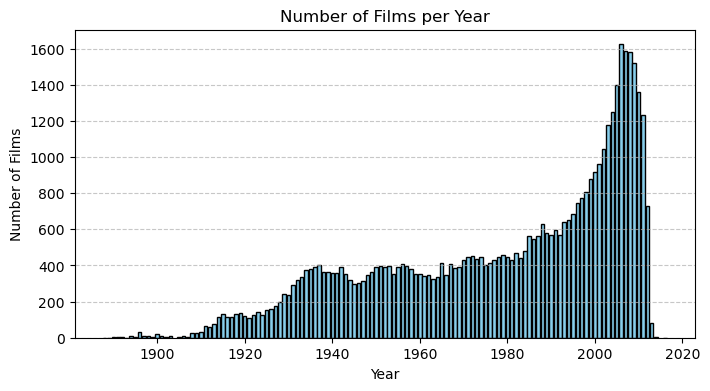

In [12]:
grouped_year = cmu_movies.groupby(cmu_movies.release_date.dt.year).agg(number_films=('movie_name','count')) \
                         .reset_index()

plt.figure(figsize=(8, 4))
plt.bar(grouped_year['release_date'], grouped_year['number_films'], color='skyblue', edgecolor='black')
plt.title('Number of Films per Year')
plt.xlabel('Year')
plt.ylabel('Number of Films')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

It seems the number of movies per year increases with years. Let's see a bit more in details how many years have less than 100, 500, 1000 movies.

In [13]:
# Print the years with less than 100, 500, and 1000 films
years_less_than_100 = grouped_year[grouped_year['number_films'] < 100]['release_date']
years_less_than_500 = grouped_year[grouped_year['number_films'] < 500]['release_date']
years_less_than_1000 = grouped_year[grouped_year['number_films'] < 1000]['release_date']

print(f'Number of years with less than 100 films: {len(years_less_than_100)}')
print(f'Number of years with less than 500 films: {len(years_less_than_500)}')
print(f'Number of years with less than 1000 films: {len(years_less_than_1000)}')

# Print the year with the max number of movies
max_films_year = grouped_year.loc[grouped_year['number_films'].idxmax(), 'release_date']
max_films_count = grouped_year['number_films'].max()
print(f'The year with the max number of films is: {max_films_year:.0f} with {max_films_count} films')

Number of years with less than 100 films: 28
Number of years with less than 500 films: 99
Number of years with less than 1000 films: 117
The year with the max number of films is: 2006 with 1624 films


We see that there are not that much years with less than 100 movies. We will drop them from our dataset, in order to have more significant results when we will do year based analysis.

In [14]:
# In the original CMU dataset remove the rows with release year with less than 100 films
years_to_remove = grouped_year[grouped_year['number_films'] < 100]['release_date'].tolist()
cmu_movies = cmu_movies[~cmu_movies.release_date.dt.year.isin(years_to_remove)].copy()

We have also the problem that so far the values in the columns 'language', 'country' and 'genre' are still in a object format and not easily usable. We will need to convert them to a more usable format. For an easy access to those values later we will interpret them as dictionaries that we'll convert to a list format since we do not need the keys (that come from freebase).

In [15]:
# Transform the object dtype into list of values:
# We use ast.literal_eval to interpret the string as a dictionnaries, we take only their values and 
# we convert it to a list
cmu_movies['language'] = cmu_movies['language'].apply(lambda x: list(ast.literal_eval(x).values())) 
cmu_movies['country'] = cmu_movies['country'].apply(lambda x: list(ast.literal_eval(x).values()))
cmu_movies['genre'] = cmu_movies['genre'].apply(lambda x: list(ast.literal_eval(x).values()))

# Check the max number of values in each list(i.e. the max number of languages, countries and genres for a movie)
print(f'The max number of values in a single list for language is {cmu_movies["language"].apply(len).max()}')
print(f'The max number of values in a single list for country is {cmu_movies["country"].apply(len).max()}')
print(f'The max number of values in a single list for genre is {cmu_movies["genre"].apply(len).max()}')

The max number of values in a single list for language is 11
The max number of values in a single list for country is 14
The max number of values in a single list for genre is 17


In [16]:
# Cleaned version of the CMU dataset
cmu_movies

,wikiID,freebase_movID,movie_name,release_date,boxoffice,runtime,language,country,genre,tconst,averageRating,numVotes
0,975900,/m/03vyhn,ghosts of mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",tt0228333,4.9,56928
1,28463795,/m/0crgdbh,brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]",tt0094806,5.6,41
2,9363483,/m/0285_cd,white of the eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",tt0094320,6.1,2895
3,261236,/m/01mrr1,a woman in flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama],tt0083949,5.9,623
5,10408933,/m/02qc0j7,alexander's ragtime band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",tt0029852,6.8,2268
...,...,...,...,...,...,...,...,...,...,...,...,...
49986,15394941,/m/03m6zh4,gopi kishan,1994-12-02,NaN,NaN,[Hindi Language],[India],"[Drama, Action, Crime, Comedy]",tt0109922,5.8,964
49987,23851782,/m/06_vb43,the ghost train,1941-05-03,NaN,82.0,[English Language],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",tt0033660,6.2,1582
49988,35228177,/m/0j7hxnt,mermaids: the body found,2011-03-19,NaN,120.0,[English Language],[United States of America],[Drama],tt1816585,4.6,1711
49989,34980460,/m/0g4pl34,knuckle,2011-01-21,NaN,96.0,[English Language],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",tt1606259,6.8,3194


In [17]:
cmu_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49473 entries, 0 to 49990
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   wikiID          49473 non-null  int64         
 1   freebase_movID  49473 non-null  object        
 2   movie_name      49473 non-null  object        
 3   release_date    49473 non-null  datetime64[ns]
 4   boxoffice       7461 non-null   float64       
 5   runtime         41686 non-null  float64       
 6   language        49473 non-null  object        
 7   country         49473 non-null  object        
 8   genre           49473 non-null  object        
 9   tconst          49473 non-null  object        
 10  averageRating   49473 non-null  float64       
 11  numVotes        49473 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(6)
memory usage: 4.9+ MB


We see here that we have enough data for our analysis.

#### 1.2 Characters dataset

Now that we have a usable and clean dataset for the movies we will interest ourselves in the character dataset. To do that let first have a look at the dataset.

In [19]:
cmu_character_cols = ['wikiID',
                      'freebase_movID',
                      'release_date',
                      'character_name',
                      'actor_birth',
                      'actor_gender',
                      'actor_height',
                      'actor_ethnicity',
                      'actor_name',
                      'actor_age_at_release',
                      'freebase_char_actor_map',
                      'freebase_charID',
                      'freebase_actorID']

cmu_character = pd.read_table(data_path+'character.metadata.tsv', names=cmu_character_cols)
cmu_character.sample(5)

,wikiID,freebase_movID,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID
413453,18903909,/m/04jb9v2,2007-09-18,NaN,1971-05-03,M,1.78,/m/0x67,Damon Dash,36.0,/m/0gxjywh,NaN,/m/04d9yz
205412,930143,/m/03q_rz,2002-01-12,Lester,NaN,M,NaN,NaN,Jon Shere,NaN,/m/06khdfk,/m/06khdfn,/m/06khdfw
211642,30494332,/m/0g9y77f,2010-10-02,NaN,1965-02-17,M,NaN,NaN,Fukikoshi Mitsuru,45.0,/m/0gbv54m,NaN,/m/0k2vjd
169124,14148678,/m/03cw3h5,1991-12-01,NaN,1968-08-09,M,1.70,/m/0fk1z,Chris Stone,23.0,/m/06454cq,NaN,/m/0642k_
12580,665883,/m/0312_c,1992,NaN,1953-07-22,F,NaN,NaN,Sylvia Chang,38.0,/m/0cg10r0,NaN,/m/0dw97v


In [20]:
cmu_character.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450669 entries, 0 to 450668
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   wikiID                   450669 non-null  int64  
 1   freebase_movID           450669 non-null  object 
 2   release_date             440674 non-null  object 
 3   character_name           192794 non-null  object 
 4   actor_birth              344524 non-null  object 
 5   actor_gender             405060 non-null  object 
 6   actor_height             154824 non-null  float64
 7   actor_ethnicity          106058 non-null  object 
 8   actor_name               449441 non-null  object 
 9   actor_age_at_release     292556 non-null  float64
 10  freebase_char_actor_map  450669 non-null  object 
 11  freebase_charID          192804 non-null  object 
 12  freebase_actorID         449854 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 44.7+ MB


We will first drop any null value we have on the wikiID column or in the freebase_actorID column since we don't want character without actor or movie, we also drop the dupplicates if we have more than one character for the same actor in the same movie.

In [21]:
cmu_character.dropna(subset=['wikiID','freebase_actorID'], inplace=True)
cmu_character.drop_duplicates(subset=['wikiID','freebase_actorID'], inplace=True)

We will now create a dataset containing the information about the actors and the movies they played in.

In [22]:
actor_movie = cmu_character.drop(columns='release_date', axis=1) \
                           .merge(cmu_movies[['wikiID','averageRating','numVotes','release_date','tconst']],
                                  on='wikiID',how='inner')
actor_movie.head(5)

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,averageRating,numVotes,release_date,tconst
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,4.9,56928,2001-08-24,tt0228333
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,4.9,56928,2001-08-24,tt0228333
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,4.9,56928,2001-08-24,tt0228333
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,4.9,56928,2001-08-24,tt0228333
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,4.9,56928,2001-08-24,tt0228333


In [23]:
# We also add the principal actors for each movie
imdb_principals = pd.read_csv(data_path+'name_principals.csv')
imdb_principals.primaryName  = imdb_principals.primaryName.str.lower()
imdb_principals['is_principal'] = 1

actor_movie = actor_movie.merge(imdb_principals,
                                how="left",
                                left_on=['tconst',actor_movie.actor_name.str.lower()],
                                right_on=['tconst','primaryName']).drop(columns=['tconst','primaryName'])
actor_movie['is_principal'].fillna(0, inplace = True)

cmu_character = actor_movie.drop(columns=['averageRating','numVotes']).copy()
cmu_character

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,release_date,is_principal
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001-08-24,0.0
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001-08-24,0.0
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001-08-24,1.0
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001-08-24,1.0
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001-08-24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331111,9971909,/m/02pygw1,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5,1972-09-22,1.0
331112,9971909,/m/02pygw1,NaN,1918-10-02,M,NaN,NaN,Herb Voland,53.0,/m/0ggdv2_,NaN,/m/02qylb9,1972-09-22,1.0
331113,28308153,/m/0cp05t9,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,1957-01-01,1.0
331114,28308153,/m/0cp05t9,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,1957-01-01,0.0


We will now compute a fame score for each actor basing ourselves on the three previous movies he played in to have for every actor a first carreer success indicator. This is subject to change but for the 2nd milestone this first version of the fame score is satisfying (we will show this later on).

Now that we a cleaned dataset of character with the corresponding fame score of each actor, we would like that have more information on the character the actor is playing in this movie. For that we will use the persona dataset to be able later to understand the relation between the character and the actor. 

In [24]:
acl_persona_cols = ['entity_id',
                    'wikiID',
                    'movie_name',
                    'entity_name',
                    'full_entity_name',
                    'entity_num_event',
                    'persona',
                    'final_posterior']

acl_persona = pd.read_table(acl_persona_path+'25.100.lda.log.txt', header=None, names=acl_persona_cols)
acl_persona.sample(5)

,entity_id,wikiID,movie_name,entity_name,full_entity_name,entity_num_event,persona,final_posterior
94603,e28,2853280,Waves,she,his wife,9,13,0.00000 0.00000 0.00000 0.00000 0.00000 0.0000...
176244,e3,9629572,Polladhavan,he,he,3,28,0.00000 0.00000 0.00000 0.11000 0.00000 0.0000...
98130,e4,29397587,Olympiyan Anthony Adam,she,her,3,3,0.00000 0.00000 0.00000 0.67000 0.00000 0.0000...
25143,e12,14278837,"Something, Something, Something Dark Side",Yoda,Yoda,8,34,0.00000 0.06000 0.05000 0.00000 0.00000 0.0500...
64308,e11,22536936,City Island,she,Vince 's wife,4,13,0.00000 0.00000 0.00000 0.00000 0.00000 0.0000...


We want now to populate our cmu_character dataframe with those informations about the personas.

In [25]:
cmu_character = cmu_character.merge(acl_persona[['entity_id','persona']], 
                                    left_on='freebase_char_actor_map', 
                                    right_on='entity_id', how='left').drop(columns='entity_id')

# Print the final dataset
cmu_character

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,release_date,is_principal,persona
0,975900,/m/03vyhn,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001-08-24,0.0,NaN
1,975900,/m/03vyhn,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001-08-24,0.0,35.0
2,975900,/m/03vyhn,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001-08-24,1.0,NaN
3,975900,/m/03vyhn,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001-08-24,1.0,NaN
4,975900,/m/03vyhn,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001-08-24,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331125,9971909,/m/02pygw1,NaN,1938-11-26,M,NaN,NaN,Rich Little,33.0,/m/02vbk4r,NaN,/m/03m6t5,1972-09-22,1.0,NaN
331126,9971909,/m/02pygw1,NaN,1918-10-02,M,NaN,NaN,Herb Voland,53.0,/m/0ggdv2_,NaN,/m/02qylb9,1972-09-22,1.0,NaN
331127,28308153,/m/0cp05t9,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,1957-01-01,1.0,NaN
331128,28308153,/m/0cp05t9,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,1957-01-01,0.0,NaN


In [26]:
cmu_character.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331130 entries, 0 to 331129
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   wikiID                   331130 non-null  int64         
 1   freebase_movID           331130 non-null  object        
 2   character_name           151480 non-null  object        
 3   actor_birth              255770 non-null  object        
 4   actor_gender             299183 non-null  object        
 5   actor_height             122653 non-null  float64       
 6   actor_ethnicity          80718 non-null   object        
 7   actor_name               330836 non-null  object        
 8   actor_age_at_release     225058 non-null  float64       
 9   freebase_char_actor_map  331130 non-null  object        
 10  freebase_charID          151485 non-null  object        
 11  freebase_actorID         331130 non-null  object        
 12  release_date    

# Fame score computation

First consider the data we have for each movies. We have the number of votes, the rate, the principal actors and also the date of release. One can assume that an actor fame will increase after a good movie and then decrease exponentially while he is not appearing in any other movies. This is the kind of shape we expect for a fame score.

We can first evaluate the instantaneous fame of an actor in a specific movie. It should be related to all the parameters we mentionned. But one can note that the overall number of votes increase with the time so we need to rescale it.

In [27]:
actor_movie.sample(5)

,wikiID,freebase_movID,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_at_release,freebase_char_actor_map,freebase_charID,freebase_actorID,averageRating,numVotes,release_date,is_principal
175422,22322537,/m/05s_rg0,Clarisse,1976-08-18,F,1.70,/m/0x67,Daphnée Duplaix,22.0,/m/0n5_z83,/m/0n5_z86,/m/061s3p,4.9,7425,1999-04-09,0.0
2464,12180811,/m/02vt7xf,NaN,1961-11-14,M,1.83,NaN,D. B. Sweeney,24.0,/m/0gcl7nz,NaN,/m/026jp3,6.3,1855,1986-05-09,0.0
280692,8279688,/m/026ytsd,NaN,1900-10-24,M,NaN,NaN,I. Stanford Jolley,48.0,/m/0ggfbgz,NaN,/m/0b6hcc8,6.9,954,1949-01-01,0.0
42373,2547497,/m/07m9qh,NaN,1969-03-27,M,1.75,/m/09v5bdn,Kevin Corrigan,28.0,/m/03jr4fm,NaN,/m/0c7lcx,6.2,4166,1998-01-01,0.0
35758,28330018,/m/0cnylhn,NaN,1936,M,NaN,NaN,Kuthiravattam Pappu,55.0,/m/0gltyrl,NaN,/m/02885dh,5.4,44,1991-01-01,1.0


<function matplotlib.pyplot.show(close=None, block=None)>

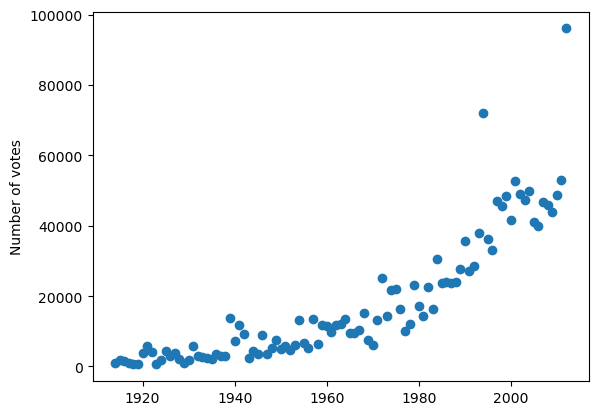

In [28]:
votes_per_year = actor_movie[['release_date','numVotes']].groupby(actor_movie['release_date'].dt.year)[['numVotes']].agg("mean")
plt.scatter(votes_per_year.index,votes_per_year.numVotes)
plt.ylabel('Number of votes')
plt.show

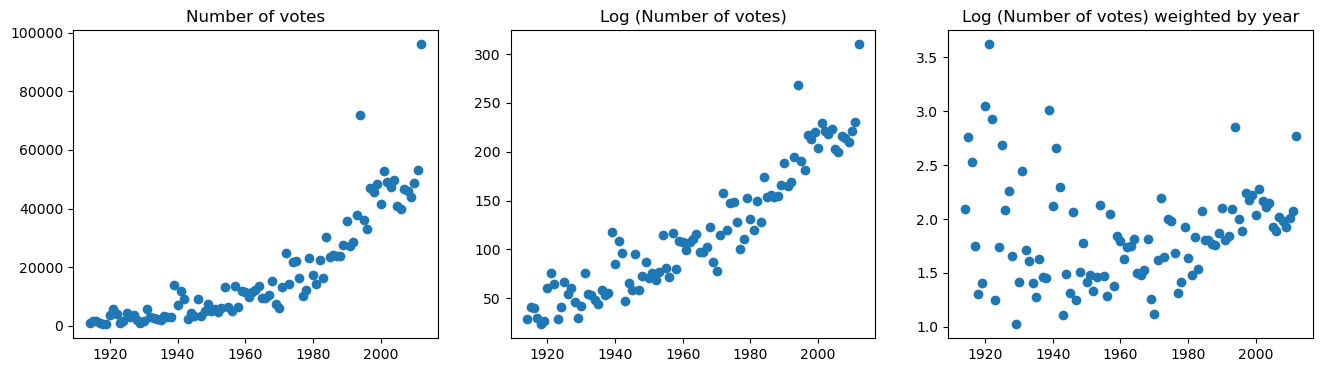

In [29]:
fig, axis = plt.subplots(1,3,figsize=(16,4))

axis[0].scatter(votes_per_year.index,votes_per_year.numVotes)
axis[0].set_title('Number of votes')

axis[1].scatter(votes_per_year.index,np.sqrt(votes_per_year.numVotes))
axis[1].set_title('Log (Number of votes)')

axis[2].scatter(votes_per_year.index,np.sqrt(votes_per_year.numVotes)/(votes_per_year.index-1900))
axis[2].set_title('Log (Number of votes) weighted by year')


plt.show()

In [30]:
def instant_fame_score(row,data):
    year = row['release_date'].year
    rate = row['averageRating']
    votes = row['numVotes']
    is_principal = row['is_principal']

    instant_fameScore = rate * np.sqrt(votes) / (year-1900) * (1 + 0.2*is_principal)

    return instant_fameScore

actor_movie.sort_values(by=['freebase_actorID','release_date'], inplace=True)
actor_movie['instant_fameScore'] = actor_movie.apply(lambda x: instant_fame_score(x,actor_movie), axis=1)

In [31]:
def get_fame_score(df, mode='before_after_films'):
    df = df.sort_values('release_date')

    dates = df['release_date'].to_numpy()
    if mode=='filmography':
        # every day between first and last films
        time_range = pd.date_range(dates[0], dates[-1], freq='D').to_list()
    elif mode=='before_after_films':
        # day before and release date of films
        time_range = np.hstack(list(map(lambda d: [d-pd.Timedelta(days=1),d-pd.Timedelta(days=0)], dates)))
    
    # make time_range non decreasing against cases with two films on the same day
    time_range = np.maximum.accumulate(time_range)
    #create a time_range for each films
    time_ranges = np.expand_dims(time_range, axis=0).repeat(axis=0,repeats=len(dates))
    #convert each time range to the number of days from film release date
    day_deltas = np.array(list(map(lambda x : list(map(lambda y,z: (y - dates[z]).days, x[1], [x[0]]*len(time_range))), enumerate(time_ranges))))
    # get exponential for each film
    exps = np.array(list(map(lambda x: np.exp(-x/4/365/5), day_deltas))) # CAN CHANGE DECAY HERE

    # mask exponential part before film release, treated in two cases to deal with films released on the same day issue
    if mode=='filmography':
        exps[exps>1] = 0
    elif mode=='before_after_films':
        idx = np.indices(exps.shape)
        mask = idx[1]<2*idx[0]+1
        exps[mask] = 0
    
    exps = np.diag(df['instant_fameScore'])@exps # CAN CHANGE SCALING HERE

    return time_range, exps.max(axis=0)

def fame_score(df, mode='before_after_films'):
    if mode=='filmography':
        return get_fame_score(df, mode='filmography')
    elif mode=='before_after_films':
        _, fame_scores = get_fame_score(df)
        df['fameScore_before']=fame_scores[2*np.arange(len(fame_scores)//2)]
        df['fameScore_after']=fame_scores[2*np.arange(len(fame_scores)//2)+1]
        return df

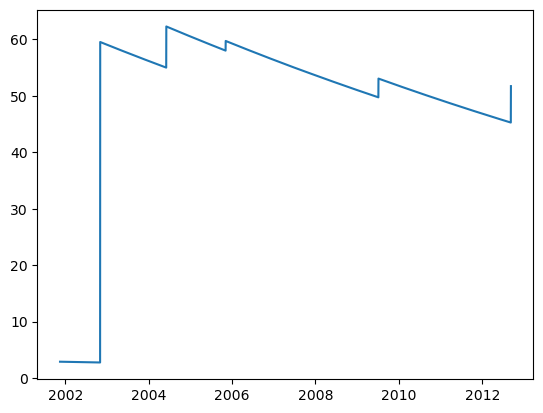

In [32]:
# df=actor_movie.query("freebase_actorID=='/m/010p3'")
df = actor_movie[actor_movie['actor_name']=='Emma Watson']
time_range, sumexps = get_fame_score(df, 'filmography')
plt.plot(time_range, sumexps)
plt.show()

In [33]:
actor_movie = actor_movie.groupby('freebase_actorID').apply(fame_score).reset_index(drop=True)
actor_movie.sample(5)

KeyboardInterrupt: 

In [56]:
actor_movie['fameScore_diff'] = actor_movie['fameScore_after']-actor_movie['fameScore_before']
cmu_character = cmu_character.merge(actor_movie[['freebase_movID','freebase_actorID','fameScore_before','fameScore_after','fameScore_diff']],on=['freebase_movID','freebase_actorID'],how='left')

In [65]:
def plot_filmography(actor_name):
    '''
    This function plots the fame score of an actor along the years and the movies he played in
    '''
    
    filmography = cmu_character.query(f"actor_name=='{actor_name}'").sort_values('release_date')
    filmography = filmography.merge(cmu_movies[['wikiID','movie_name']], on='wikiID')

    plt.figure(figsize=(10,5))
    for i,film in filmography.iterrows():
        plt.scatter(film.release_date, film.fameScore_after, label=str(i+1)+' : '+film.movie_name,
                    color='cornflowerblue')
        plt.annotate(i+1, xy=(film['release_date'],film['fameScore_after']), xytext=(4,0), textcoords='offset points')
    plt.xlabel('Year')
    plt.ylabel('Fame score')
    plt.title(f'Fame score for {actor_name} along years')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1.02))

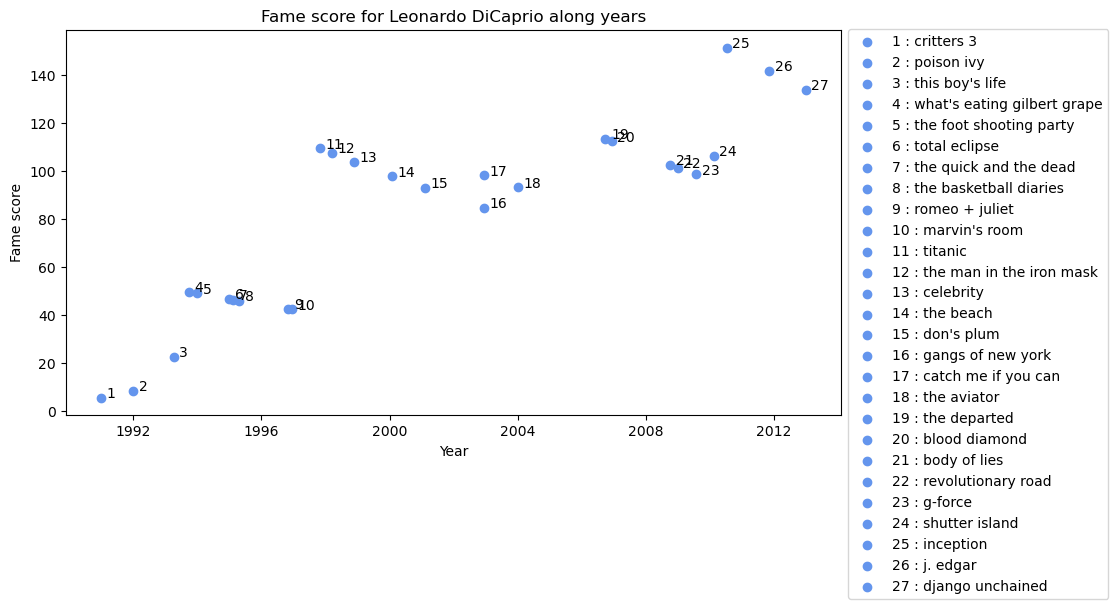

In [68]:
plot_filmography('Leonardo DiCaprio')

In [ ]:
# save the cmu_character dataset

actor_movie.to_csv(data_path+'actor_movie_sim2.csv', index=False)